In [4]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import geopandas
import contextily
import random
import seaborn as sns

# **Sieć komunikacji miejskiej miasta Wrocław**

**Źródła danych:**
* Dane odnośnie przystanków i czasu przejazdu: 
    * https://www.wroclaw.pl/open-data/dataset/rozkladjazdytransportupublicznegoplik_data
    * https://www.wroclaw.pl/linia-1-wroclaw (przykład dla linii 1)

**Opis danych:**
* Węzłami (wierzchołkami) są przystanki
* Połączeniami (krawędziami) są trasy pomiędzy przystankami (pojedyncza krawędź to przejazd autobusu/tramwaju z przystanku do przystanku)
* Krawędzie posiadają wagę, którą jest czas przejazdu danej linii od przystanku do przystanku

# **Pozyskiwanie danych**

In [5]:
routes = pd.read_csv("data/routes.txt")
stops = pd.read_csv("data/stops.txt")
trips = pd.read_csv("data/trips.txt")
stop_times = pd.read_csv("data/stop_times.txt")

In [6]:
# Niektóre połączenia nie miały opisów czasu trasy. W takim wypadku szukano połączeń w drugą stronę, które taki opis posiadały.
# Jeżeli wciąż nie znajdowano takich połączeń, to czas trasy losowano z przedziału [1, 3]
def fix_connections(connections):
    for connection in connections:
        time = connection['time']
        if time <= 0:
            source = connection['source']
            target = connection['target']
            for connection_2 in connections:
                source_2 = connection_2['source']
                target_2 = connection_2['target']
                time_2 = connection_2['time']
                if source_2 == target and target_2 == source and time_2 > 0:
                    connection['time'] = time_2
            if connection['time'] <= 0:
                connection['time'] = random.randint(1, 3) # Błędy w danych
        else:
            continue        
    return connections

# Scrappowanie czasu przejazdu
def find_times_row_route_direction(href):
    soup = BeautifulSoup(requests.get(href).content, "html.parser")
    table = soup.find('table', {'class': 'table table-bordered table-schedule hide-to-print'}).find('tbody')
    table_rows = table.findAll('tr')[1:]
    times = [row.findAll('td')[1].text for row in table_rows]
    times = [int(time) if len(time) > 0 else -1 for time in times]
    return times

# Scrappowanie połączeń
def get_connections(route_id):
    try:
        url = f"https://www.wroclaw.pl/linia-{str(route_id)}-wroclaw"
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        # find table with stops
        table = soup.find("table", {"class": "table table-bordered table-schedule"}).find("tbody")
        # find stops names in the table
        stops_names = table.findAll("a", {"class": "btn"})
        stops_names = [f"{stop.text}-{stop['href'].split('-')[-1]}" for stop in stops_names if stop.text != '']
        # find stops in specific directions
        direction_1 = [stops_names[i*2] for i in range(len(stops_names)//2)]
        direction_2 = [stops_names[i*2+1] for i in range(len(stops_names)//2)]
        # find times between stops
        dir1_href = 'https://www.wroclaw.pl' + table.find('a', {'class': 'btn btn-primary'})['href']
        dir2_href = 'https://www.wroclaw.pl' + table.find('a', {'class': 'btn btn-danger'})['href']
        dir1_times = find_times_row_route_direction(dir1_href)
        dir1_times = [time2 - time1 for time1, time2 in zip(dir1_times[:-1], dir1_times[1:])]
        dir2_times = find_times_row_route_direction(dir2_href)
        dir2_times = [time2 - time1 for time1, time2 in zip(dir2_times[:-1], dir2_times[1:])]
        # create directions stop1-stop2 for all stops
        direction_1_connections = [{'source': source, 'target': target, 'route_id': route_id, 'time': time} for source, target, time in zip(direction_1[:-1], direction_1[1:], dir1_times)]
        direction_2_connections = [{'source': source, 'target': target, 'route_id': route_id, 'time': time} for source, target, time in zip(direction_2[:-1], direction_2[1:], dir2_times)]
        # create all route connections: list of (source, target) elements
        route_connections = direction_1_connections + direction_2_connections
        route_connections = fix_connections(route_connections)
    except:
        route_connections = []
    return route_connections

In [5]:
route_ids = trips['route_id'].unique()

all_connections = []
for route_id in route_ids:
    all_connections.extend(get_connections(route_id))
    
routes_df = pd.DataFrame.from_dict(all_connections, orient='columns')
routes_df.to_csv("routes_df.csv", index=False)

In [6]:
# # Plot with geopandas
# gdf = geopandas.GeoDataFrame(stops, geometry=geopandas.points_from_xy(stops.stop_lon, stops.stop_lat), crs='EPSG:3857')
# ax = gdf.plot(markersize=1)
# contextily.add_basemap(ax, crs=gdf.crs.to_string())

# **Tworzenie grafu**

In [7]:
routes_df = pd.read_csv("routes_df.csv")
G = nx.from_pandas_edgelist(routes_df, edge_attr='time', create_using=nx.MultiDiGraph())
G2 = nx.from_pandas_edgelist(routes_df, edge_attr='time', create_using=nx.DiGraph())

In [8]:
n_G_edges, n_G2_edges = len(G.edges), len(G2.edges)
print(f"Przed usunięciem pętli i wielokrotnych krawędzi: {n_G_edges}")
print(f"Po usunięciu pętli i wielokrotnych krawędzi: {n_G2_edges}")
print(f"Ubyło {n_G_edges - n_G2_edges} krawędzi (pozostało {n_G2_edges/n_G_edges*100:.2f}% krawędzi)")

Przed usunięciem pętli i wielokrotnych krawędzi: 6204
Po usunięciu pętli i wielokrotnych krawędzi: 2643
Ubyło 3561 krawędzi (pozostało 42.60% krawędzi)


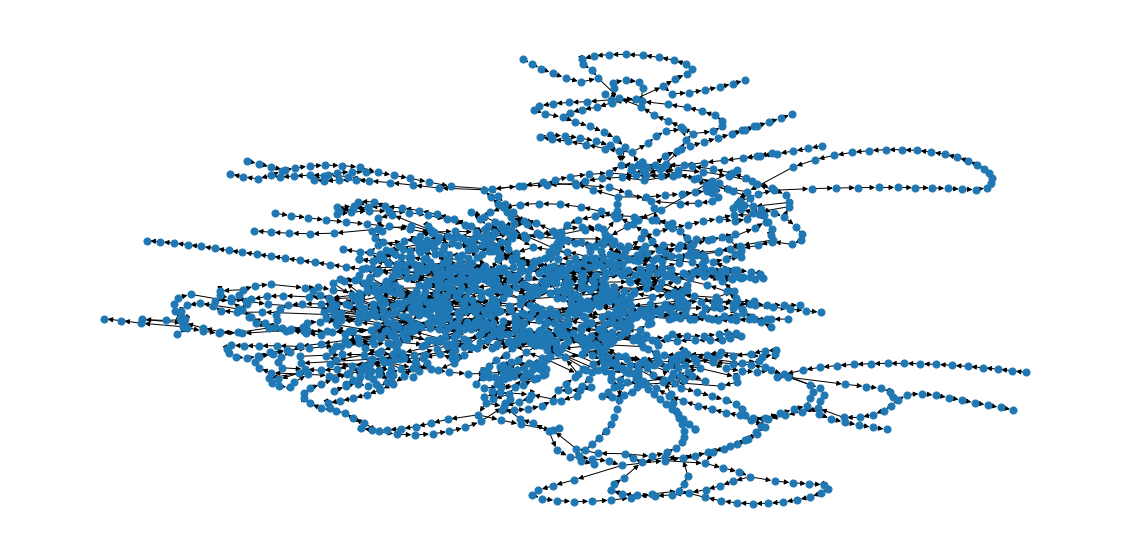

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
nx.draw_kamada_kawai(G2, node_size=50, ax=ax)

# **Analiza sieci**

## **Podstawowa analiza sieci**:
* rozkład stopni węzła
* rozkład najkrótszych ścieżek
* rozkład współczynnika grupowania
* średnica sieci
* liczba komponentów
* kluczowe węzły w sieci z punktu widzenia różnych miar
* do jakiego modelu sieci jest zbliżona nasza sieć (losowa, bezskalowa itd.)

#### rozkład stopni węzła

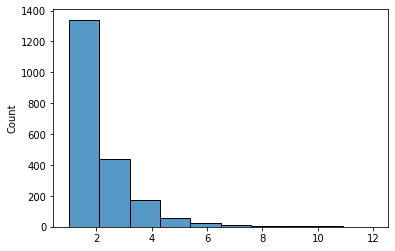

In [10]:
degrees = np.array([G2.degree(node) for node in G2.nodes])
sns.histplot(degrees, bins=10)

#### rozkład najkrótszych ścieżek

(array([2.05600e+04, 9.30250e+04, 2.65426e+05, 3.39409e+05, 4.60030e+05,
        4.17709e+05, 3.46922e+05, 2.16738e+05, 2.06983e+05, 1.49371e+05,
        9.78200e+04, 4.99580e+04, 3.82190e+04, 2.13470e+04, 1.13350e+04,
        4.86100e+03, 3.15100e+03, 1.29500e+03, 3.72000e+02, 5.40000e+01]),
 array([ 0.  ,  4.75,  9.5 , 14.25, 19.  , 23.75, 28.5 , 33.25, 38.  ,
        42.75, 47.5 , 52.25, 57.  , 61.75, 66.5 , 71.25, 76.  , 80.75,
        85.5 , 90.25, 95.  ]),
 <a list of 20 Patch objects>)

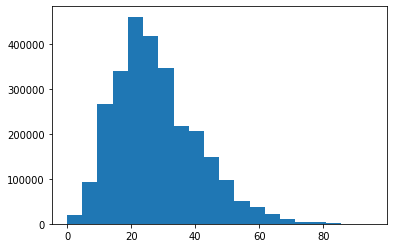

In [9]:
path_lengths = [list(x[1].values()) for x in list(nx.shortest_path_length(G2))]
path_lengths = [x for xs in path_lengths for x in xs]
plt.hist(path_lengths, bins=20)

#### rozkład współczynnika grupowania sieci

(array([1.856e+03, 2.100e+01, 2.200e+01, 4.900e+01, 1.000e+01, 5.000e+00,
        6.000e+01, 0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.200e+01]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  ]),
 <a list of 20 Patch objects>)

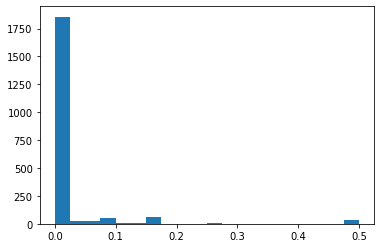

In [11]:
plt.hist(nx.clustering(G2).values(), bins=20)

#### liczba komponentów

In [12]:
print('komponenty silnie połączone:', len(list(nx.strongly_connected_components(G2))))
print('komponenty słabo połączone:', len(list(nx.weakly_connected_components(G2))))

komponenty silnie połączone: 313
komponenty słabo połączone: 2


#### kluczowe węzły w sieci z punktu widzenia różnych miar

bliskość

In [29]:
d = nx.closeness_centrality(G2)
sorted_closeness_centrality =  sorted(d, key=d.get, reverse=True)[:10]
pd.Series({k: round(d[k], 4) for k in sorted_closeness_centrality})

GALERIA DOMINIKAŃSKA-10111    0.0459
GALERIA DOMINIKAŃSKA-10126    0.0458
skwer Krasińskiego-20337      0.0457
PL. JANA PAWŁA II-10501       0.0453
DWORZEC AUTOBUSOWY-11321      0.0451
Katedra-20909                 0.0446
Dyrekcyjna-21101              0.0442
Ogród Botaniczny-20903        0.0442
PL. GRUNWALDZKI-20916         0.0440
Katedra-20931                 0.0438
dtype: float64

stopień

In [30]:
d = dict(nx.degree(G2))
sorted_degree =  sorted(d, key=d.get, reverse=True)[:10]
pd.Series({k: round(d[k], 4) for k in sorted_degree})

DWORZEC AUTOBUSOWY-21121                     12
GALERIA DOMINIKAŃSKA-10126                   10
PL. JANA PAWŁA II-10501                      10
Arkady (Capitol)-10366                        9
Hallera-11304                                 9
GALERIA DOMINIKAŃSKA-10111                    9
Psie Pole (Rondo Lotników Polskich)-29128     9
Hallera-11303                                 9
DWORZEC AUTOBUSOWY-21102                      9
KROMERA-24112                                 8
dtype: int64

betweenness centrality

In [32]:
d = nx.betweenness_centrality(G2)
sorted_betweenness =  sorted(d, key=d.get, reverse=True)[:10]
pd.Series({k: round(d[k], 4) for k in sorted_betweenness})

Kwiska-12318                                  0.1005
Wejherowska-12315                             0.1004
GALERIA DOMINIKAŃSKA-10126                    0.0867
FAT-11707                                     0.0716
Wrocławski Park Technologiczny-12150          0.0716
Psie Pole-29103                               0.0691
Psie Pole (Rondo Lotników Polskich)-29128     0.0647
GALERIA DOMINIKAŃSKA-10111                    0.0632
Biskupice Podgórne LG Electronics-70344001    0.0626
Arkady (Capitol)-10365                        0.0625
dtype: float64

#### do jakiego modelu sieci jest zbliżona nasza sieć (losowa, bezskalowa itd.)

## **Analiza grup w sieci**
* jakie grupy występują w naszej sieci
* ile ich jest, jak są połączone, jakiej są wielkości
* z czego może wynikać dany podział
* jak wygląda podział na grupy z punktu widzenia różnych algorytmów do ekstrakcji grup.

#### jakie grupy występują w naszej sieci

#### ile ich jest, jak są połączone, jakiej są wielkości

#### z czego może wynikać dany podział

#### jak wygląda podział na grupy z punktu widzenia różnych algorytmów do ekstrakcji grup.

## **Analiza wizualna sieci**
* różne layouty
* różne sposoby kolorowania, kształtu, wielkości wierzchołków 
    * w zależności od wartości poszczególnych miar
    * w zależności od podziału na grupy
* wizualizacja tylko wycinka sieci (np. jednej grupy) itd.

#### różne layouty

#### różne sposoby kolorowania, kształtu, wielkości wierzchołków

##### w zależności od wartości poszczególnych miar

##### w zależności od podziału na grupy

#### wizualizacja tylko wycinka sieci (np. jednej grupy) itd.

## **Analiza rozprzestrzeniania w sieci**
* jak rozprzestrzenia się informacja
* wpływ wirusa w Waszej sieci w zależności od różnych warunków np. 
    * jak wygląda proces gdy zaczniemy od wierzchołka X, Y, Z
    * jak wygląda proces gdy „zaszczepimy” węzły A, B, C
    * kogo musimy, zaszczepić/odizolować by w przypadku wybuchu epidemii w jednej grupie społecznej nie przedostała się ona do innych
    * co jeżeli mamy ograniczoną liczbę szczepionek albo szczepionki przychodzą partiami i danego dnia możemy zaszczepić ograniczoną liczbę osób itp.

#### jak rozprzestrzenia się informacja

#### wpływ wirusa w Waszej sieci w zależności od różnych warunków

##### jak wygląda proces gdy zaczniemy od wierzchołka X, Y, Z

##### jak wygląda proces gdy „zaszczepimy” węzły A, B, C

##### kogo musimy, zaszczepić/odizolować by w przypadku wybuchu epidemii w jednej grupie społecznej nie przedostała się ona do innych

##### co jeżeli mamy ograniczoną liczbę szczepionek albo szczepionki przychodzą partiami i danego dnia możemy zaszczepić ograniczoną liczbę osób itp.